In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
!pip install graphviz

In [2]:
def f(x):
    return 3*x**2- 4*x + 5

In [3]:
def f(x):
    return 3*x**2- 4*x + 5

In [4]:
f(3.0)

20.0

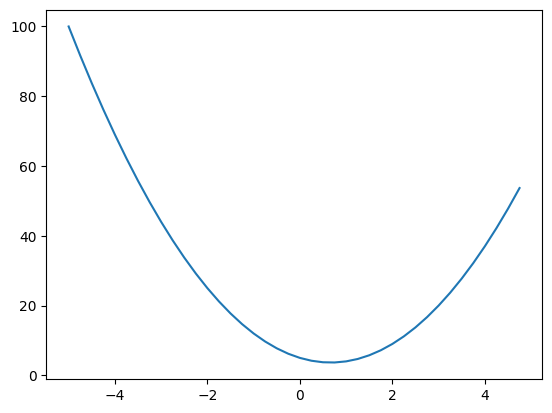

In [5]:
xs=np.arange(-5,5,0.25)
ys=f(xs)
plt.plot(xs,ys)

In [6]:
h=0.00000001
x=2/3
(f(x+h)-f(x))/h


0.0

In [7]:
a=2.0
b=-3.0
c=10.0
d=a*b+c
print(d)

4.0


In [8]:
h=0.0001
a=2.0
a=2.0
b=-3.0
c=10.0
d1=a*b+c
c+=h
d2=a*b+c
print("d1",d1)
print('d2',d2)
print('slope',(d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [9]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def __radd__(self, other): # other + self
    return self + other

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')
    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [10]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [11]:
# visualize the expresson graph

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [12]:
f.grad=4.0
d.grad=-2.0
c.grad=-2.0
e.grad=-2.0
a.grad=6.0
b.grad=-4.0

In [13]:
L.grad=1

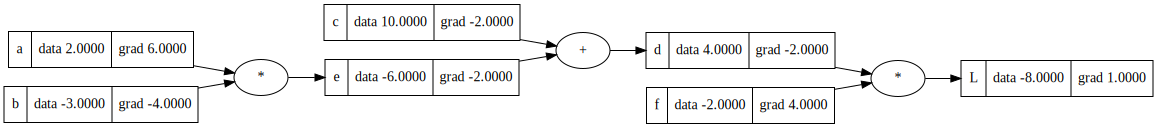

In [14]:
draw_dot(L)

In [15]:
def lol():
    h=0.001
    a=Value(2.0,label='a')
    b=Value(-3.0,label='b')
    c=Value(10.0,label='c')
    e=a*b;e.label='e'
    d=e+c;d.label='d'
    f=Value(-2.0,label='f')
    L=d*f;L.label='L'
    L1=L.data

    a=Value(2.0 ,label='a')
    b=Value(-3.0,label='b')
    c=Value(10.0,label='c')
    c.data+=h
    e=a*b;e.label='e'
    d=e+c;d.label='d'
    f=Value(-2.0,label='f')
    L=d*f;L.label='L'
    L2=L.data

    print((L2-L1)/h)

lol()

-1.9999999999988916


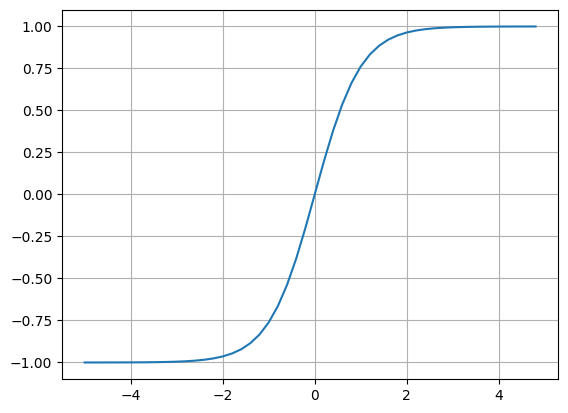

In [16]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

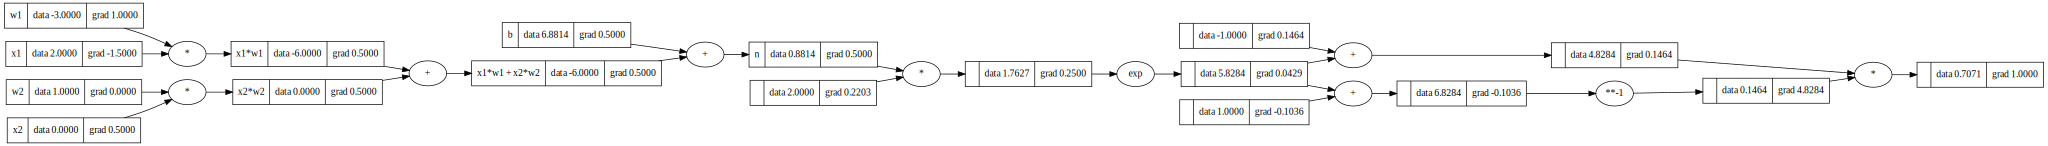

In [17]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# o = n.tanh(); o.label = 'o'

e = (2*n).exp()
o = (e - 1) / (e + 1)

o.backward()
draw_dot(o)

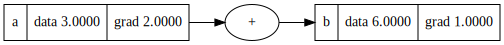

In [18]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'

b.backward()
draw_dot(b)

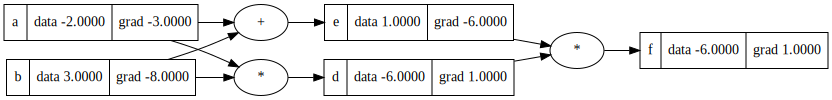

In [19]:


a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)



In [25]:
import torch
import random

In [21]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [45]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self,x):
   act= sum((wi*xi for wi,xi in zip(self.w,x)), self.b)  # dot product
   out=act.tanh()
   return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

x=[2.0,3.0,-1.0]
n=MLP(3,[4,4,1])
n(x)

Value(data=0.35765709888385655)

In [47]:
n.parameters()

[Value(data=0.34727137926631196),
 Value(data=-0.8976536723919915),
 Value(data=0.772653837387885),
 Value(data=0.8134132118534307),
 Value(data=0.2785154944362433),
 Value(data=-0.011686926188777803),
 Value(data=0.8620275747963954),
 Value(data=0.05466567472296247),
 Value(data=0.9686760920836761),
 Value(data=0.22376828046012628),
 Value(data=0.5106730331780898),
 Value(data=-0.3381021265044985),
 Value(data=-1.0231766274219467),
 Value(data=-0.6518142945357737),
 Value(data=-0.6283874821522376),
 Value(data=-0.4956362755775809),
 Value(data=0.6354766041609484),
 Value(data=0.2992754707971931),
 Value(data=0.6437783823571616),
 Value(data=0.7793538055927306),
 Value(data=0.1820547538052566),
 Value(data=1.0940591050319268),
 Value(data=0.7754096954583838),
 Value(data=-0.34778261549737516),
 Value(data=0.3218457157676758),
 Value(data=0.16536002825497567),
 Value(data=-1.0366228472591283),
 Value(data=-0.7101945285547255),
 Value(data=0.07870193841658436),
 Value(data=-0.83988940985

In [42]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [49]:
for k in range(1000):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass and we need to make the added up grads to 0
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)

0 0.0021781826809656097
1 0.0021572902411901816
2 0.0021367784345618615
3 0.002116637128519315
4 0.0020968565436199275
5 0.0020774272383818617
6 0.002058340094897044
7 0.0020395863051697895
8 0.0020211573581389226
9 0.0020030450273439276
10 0.001985241359198326
11 0.0019677386618355383
12 0.0019505294944954978
13 0.0019336066574210887
14 0.0019169631822368468
15 0.0019005923227827406
16 0.0018844875463787385
17 0.0018686425254963513
18 0.001853051129815558
19 0.0018377074186463542
20 0.0018226056336957692
21 0.0018077401921619764
22 0.0017931056801386931
23 0.001778696846313363
24 0.0017645085959444994
25 0.0017505359851035436
26 0.0017367742151679316
27 0.0017232186275528494
28 0.0017098646986695252
29 0.0016967080350988352
30 0.0016837443689698697
31 0.0016709695535329996
32 0.001658379558918259
33 0.001645970468070068
34 0.0016337384728497615
35 0.0016216798702978117
36 0.001609791059048453
37 0.001598068535889379
38 0.0015865088924596346
39 0.001575108812079457
40 0.001563865066705